<a href="https://colab.research.google.com/github/KarsonLeperi/TimeSeriesProjects/blob/main/ts_machineLearning_energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Going through the time series forecasting youtube video (Time Series Forecasting with XGBoost - Use python and machine learning to predict energy consumption). Using machine learning to predict energy data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import io
from google.colab import files

from sklearn.metrics import mean_squared_error

In [ ]:
 uploaded = files.upload()

Saving AEP_hourly.csv to AEP_hourly.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['AEP_hourly.csv']))
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values('Datetime', inplace=True) #The data is not sorted in the csv file (discovered during later analysis). This will clean it up
df = df.set_index('Datetime')
df.head(10)

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


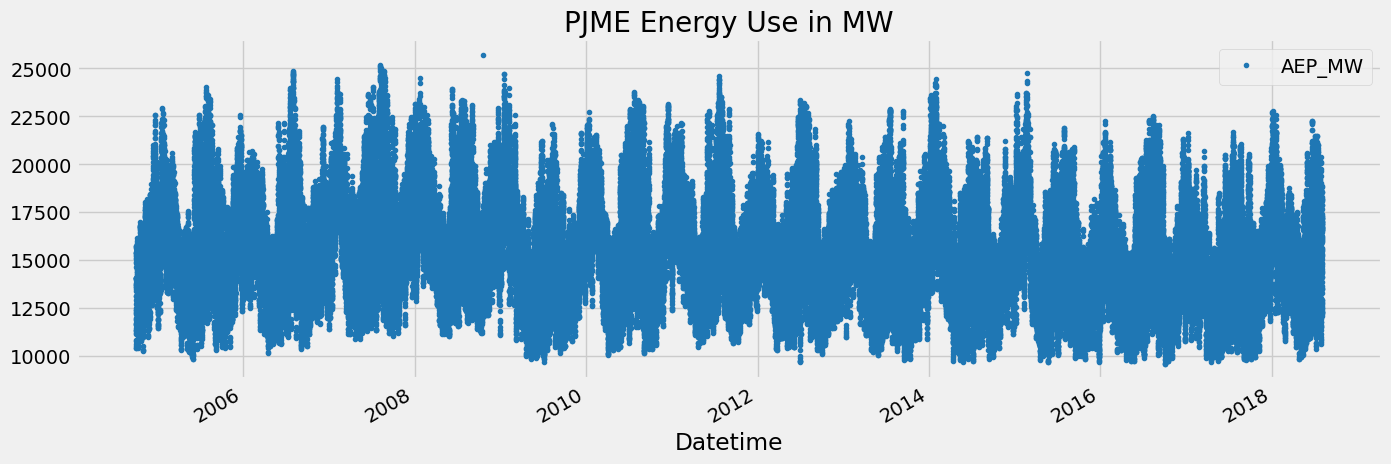

In [ ]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

#Train/Test Split

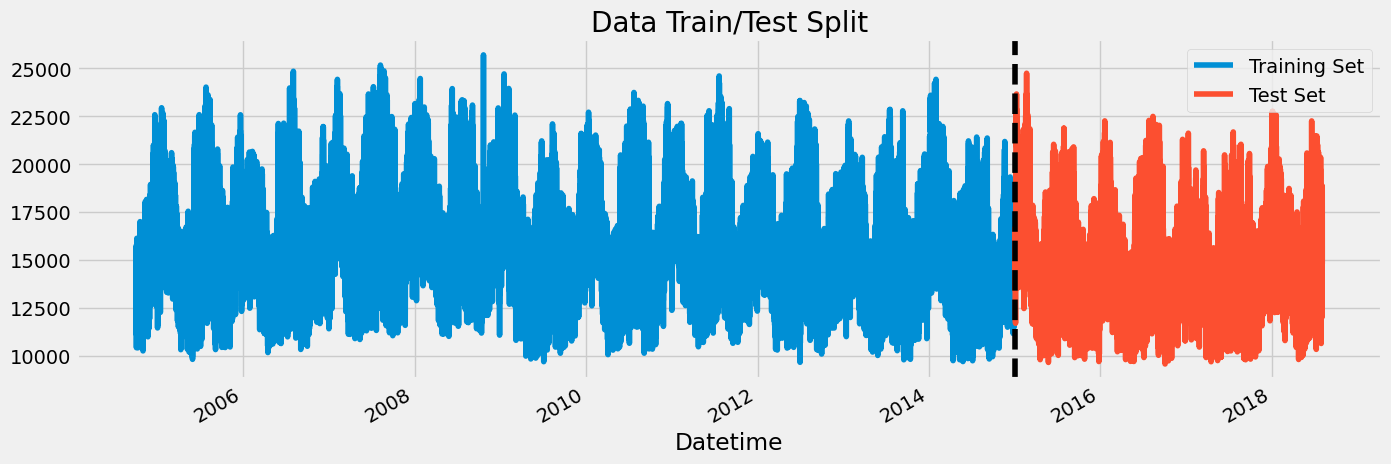

In [ ]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

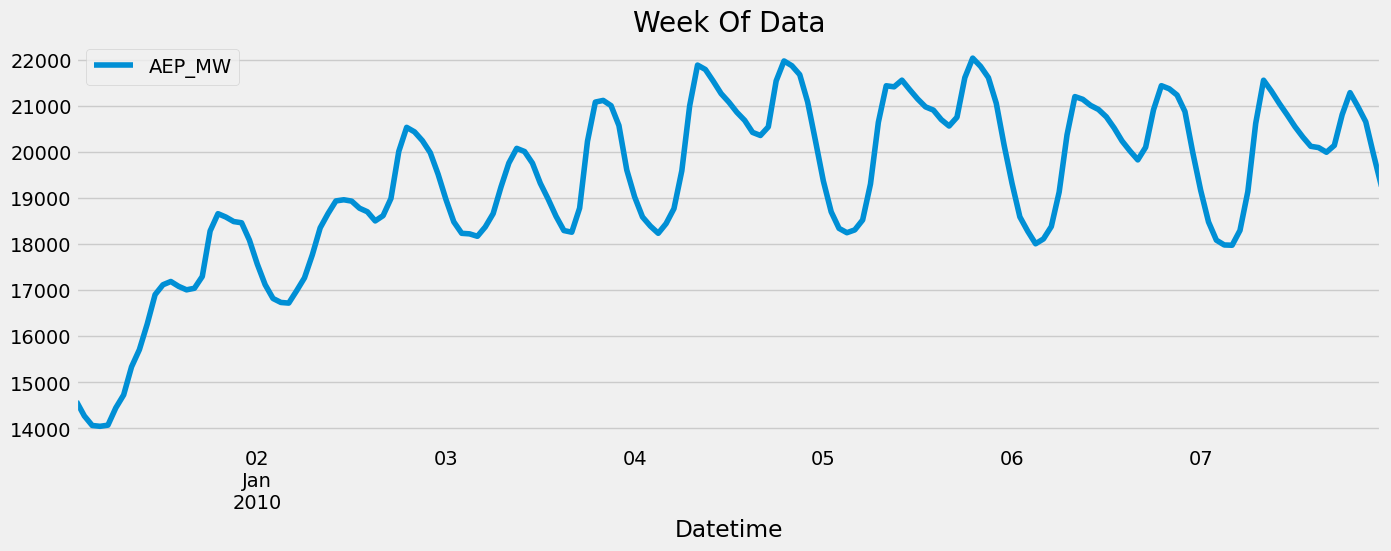

In [ ]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

#Feature Creation

In [ ]:
def create_features(df):
  """
  Create time series features based on time series index.
  """
  df = df.copy()

  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week

  return df

df = create_features(df)
df.head()


,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,1,40
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,1,40
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,1,40
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,1,40
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,1,40


#Visualize Feature

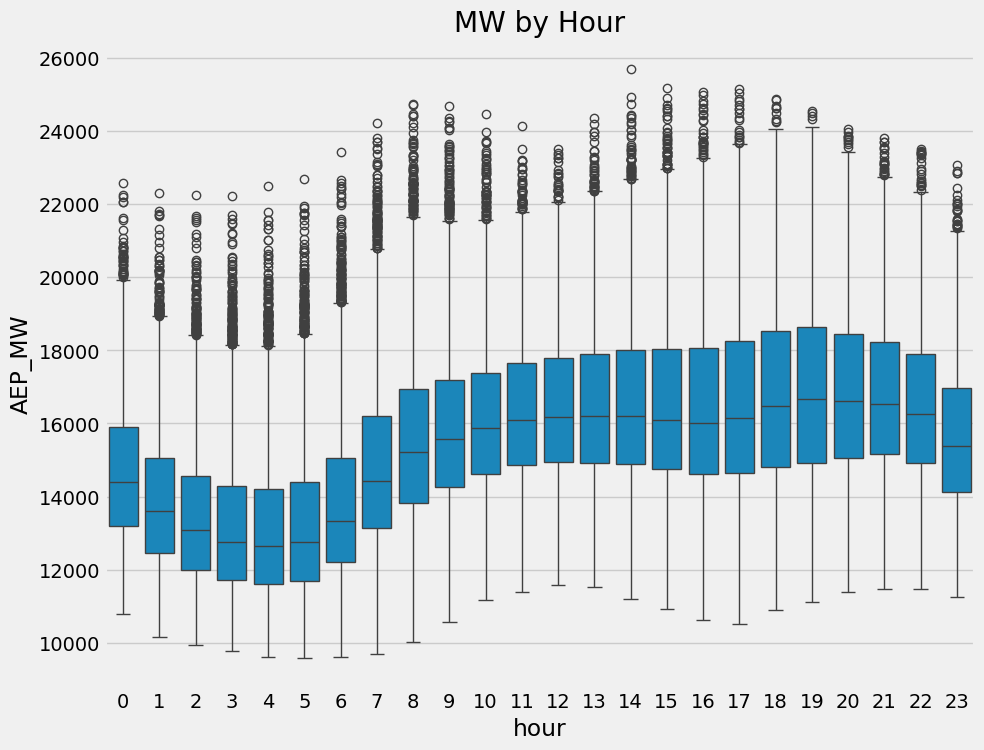

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

/tmp/ipython-input-1997979185.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='AEP_MW',palette='Blues')


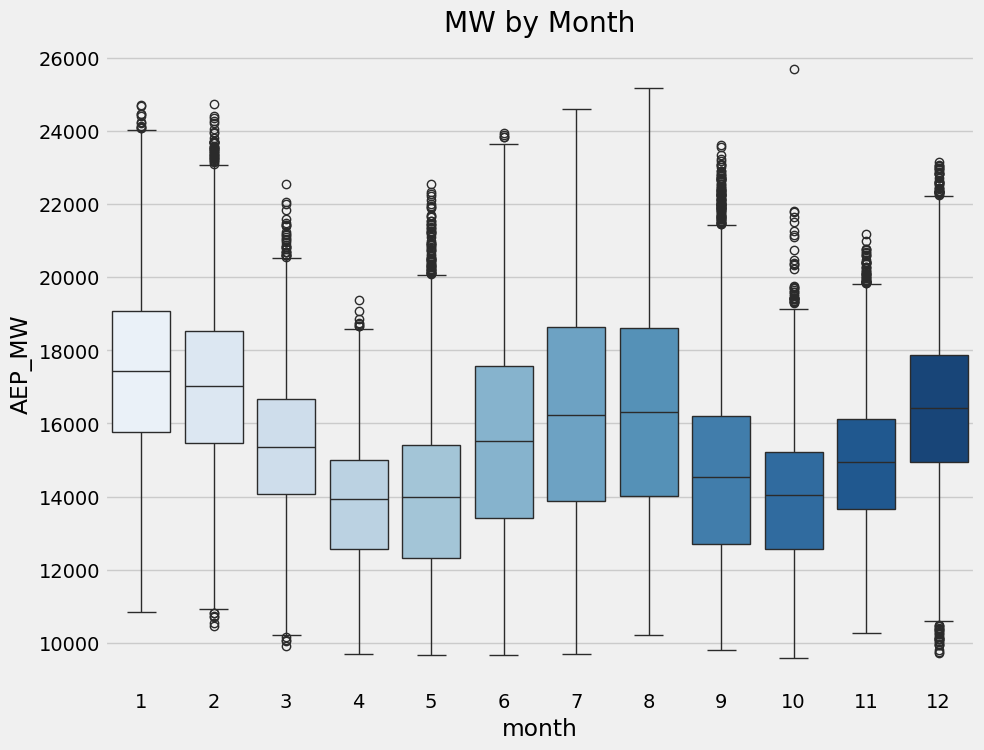

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW',palette='Blues')
ax.set_title('MW by Month')
plt.show()

#Create Model

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[100]	validation_0-rmse:1667.99304	validation_1-rmse:1906.43321
[200]	validation_0-rmse:1388.41609	validation_1-rmse:1728.03964
[300]	validation_0-rmse:1260.06288	validation_1-rmse:1670.94367
[400]	validation_0-rmse:1170.54347	validation_1-rmse:1651.32523
[500]	validation_0-rmse:1113.48343	validation_1-rmse:1643.19503
[545]	validation_0-rmse:1091.20163	validation_1-rmse:1646.54135


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

#Feature Importance

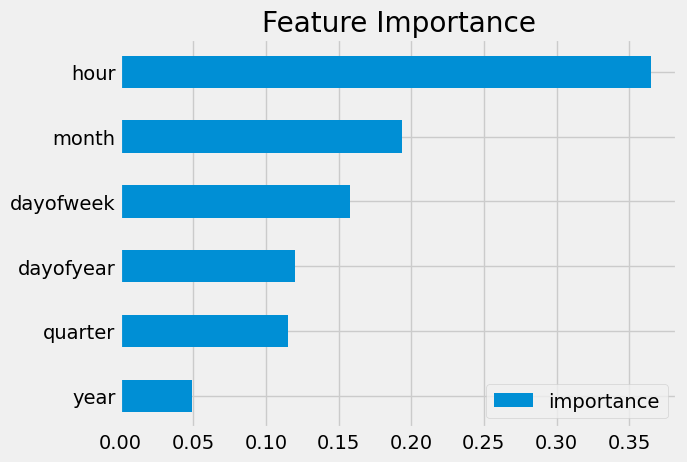

In [ ]:
fi = pd.DataFrame(reg.feature_importances_,
             index = reg.feature_names_in_,
             columns=['importance']).sort_values('importance')

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

As expected, the most important features are hour, month, and day of week. Day of year and quarter are probably excess variables that couold be infered from the first three variables.

#Forecast on Test

In [ ]:
test['prediction'] = reg.predict(X_test)
test.head()


,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2015-01-01 00:00:00,16375.0,0,3,1,1,2015,1,1,1,16409.544922
2015-01-01 01:00:00,16172.0,1,3,1,1,2015,1,1,1,15945.625000
2015-01-01 02:00:00,15968.0,2,3,1,1,2015,1,1,1,15893.853516
2015-01-01 03:00:00,15749.0,3,3,1,1,2015,1,1,1,15935.795898
2015-01-01 04:00:00,15727.0,4,3,1,1,2015,1,1,1,15935.795898


In [ ]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df.tail()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,2,31,18112.775391
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,2,31,18112.775391
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,2,31,17780.941406
2018-08-02 23:00:00,15964.0,23,3,3,8,2018,214,2,31,16259.825195
2018-08-03 00:00:00,14809.0,0,4,3,8,2018,215,3,31,14421.719727


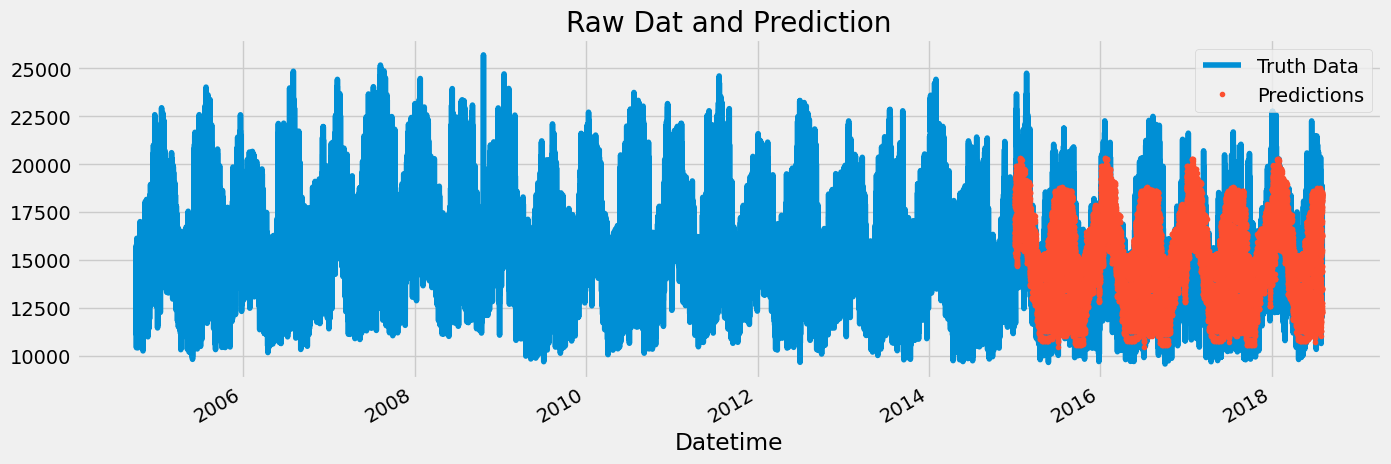

In [ ]:
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

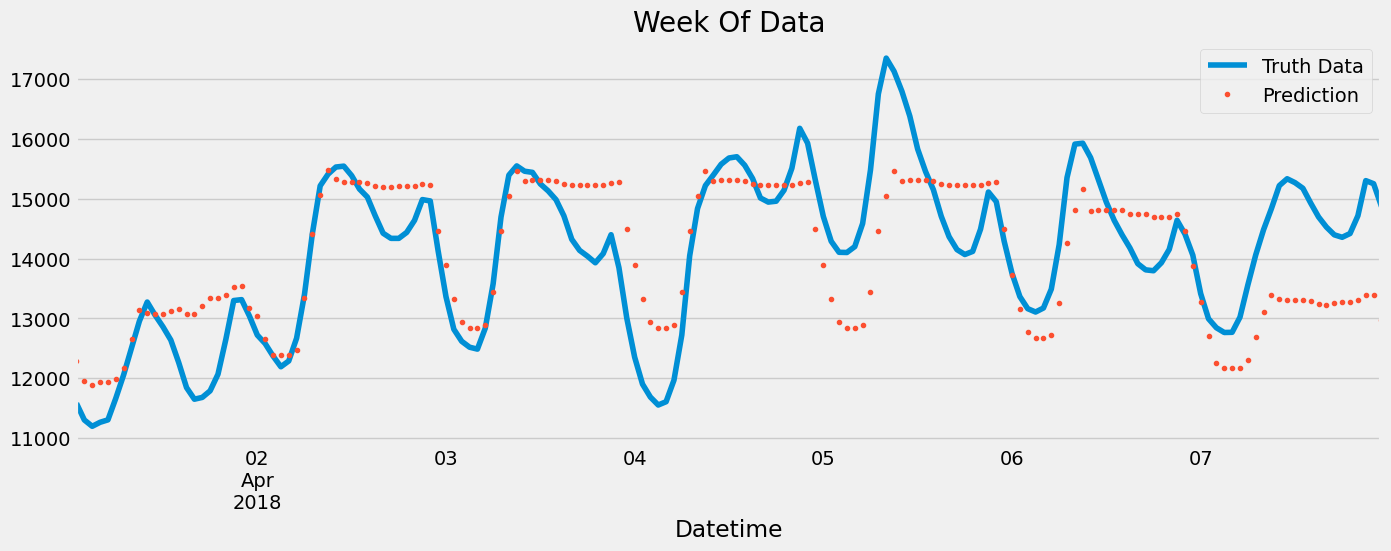

In [ ]:

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1643.09


In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

,error
date,
2017-01-22,4872.108968
2015-02-20,4861.401571
2015-02-19,4769.359985
2018-01-06,4403.549683
2017-02-07,4290.881022
2018-01-07,4202.593099
2017-01-03,4168.695475
2016-02-03,4092.213298
2017-01-23,4076.364746


At this point, I will begin exploring on my own. All of the worse performing points are in the January and February. Lets look at January and February of 2017 which contains 5 of the data points.

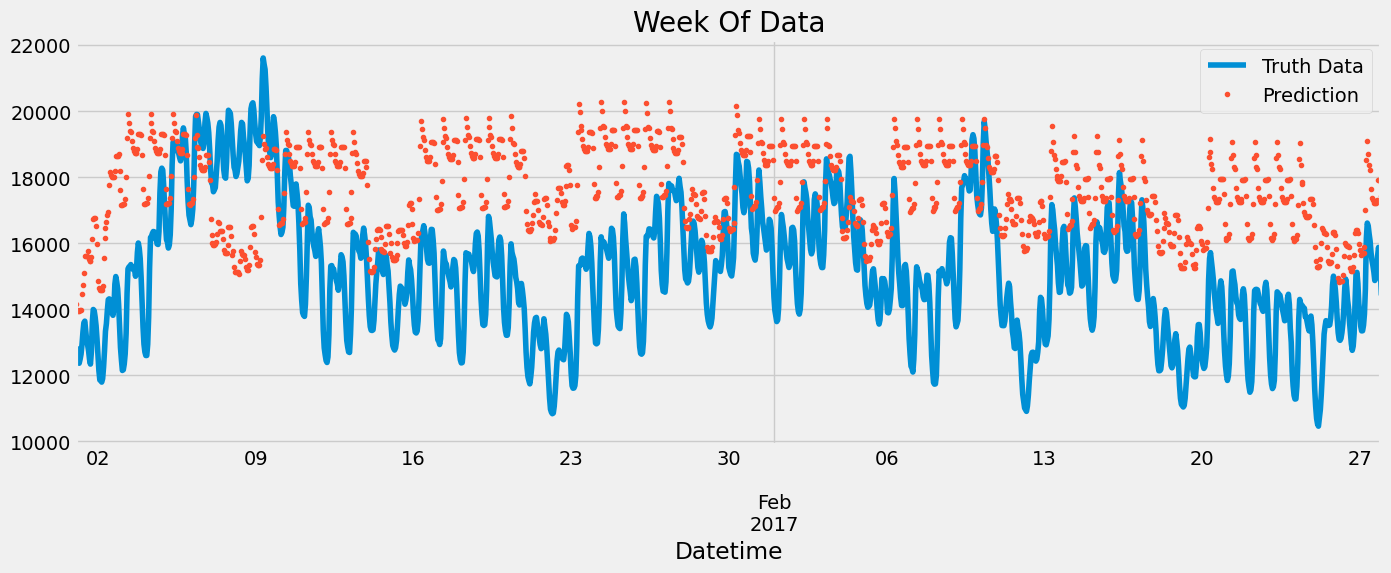

In [ ]:
ax = df.loc[(df.index > '01-01-2017') & (df.index < '02-28-2017')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2017') & (df.index < '02-28-2017')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Hmm, it looks like most of the errors are overpredictions (predicting higher energy usage than expected). Seeing that AEP is the electric utility for Ohio, I would hypothesize a significant amount of the energy usage would be related to heating homes. If there is unseasonably warm weather in January and February, we would possibly see a reduction in energy usage that would not be accruately preducted. I seem to remember (I was living in Chicago at the time) that the 2017 winter was relatively mild compared to other years.

Looking at the weather data (weather.gov) from January 2017 for Columbus, OH, the average high in January 2017 was 7 degrees greater than normal. The average low was 8 degrees greater than normal. Diving into the data further, we can see that on January 22, 2017 (highest error), the daily high was 64 deg F, 27 deg above normal. This would seem to confirm my hypothesis that the error is due to abnormally hot weather in the winter.

In terms of improving the prediction, the easiest addition would be to add a variable incorporating weather data. Based off of the exploration above, a variable tracking the difference between the expected high and the average high for the data would supply the most information.